In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
from scipy.stats import norm

In [6]:
# custom libs
import sys
sys.path.append("../..") # se subir de pasta, "../" em vez de "../.../"

from src.libs.dynamicFPC import W_dFPC

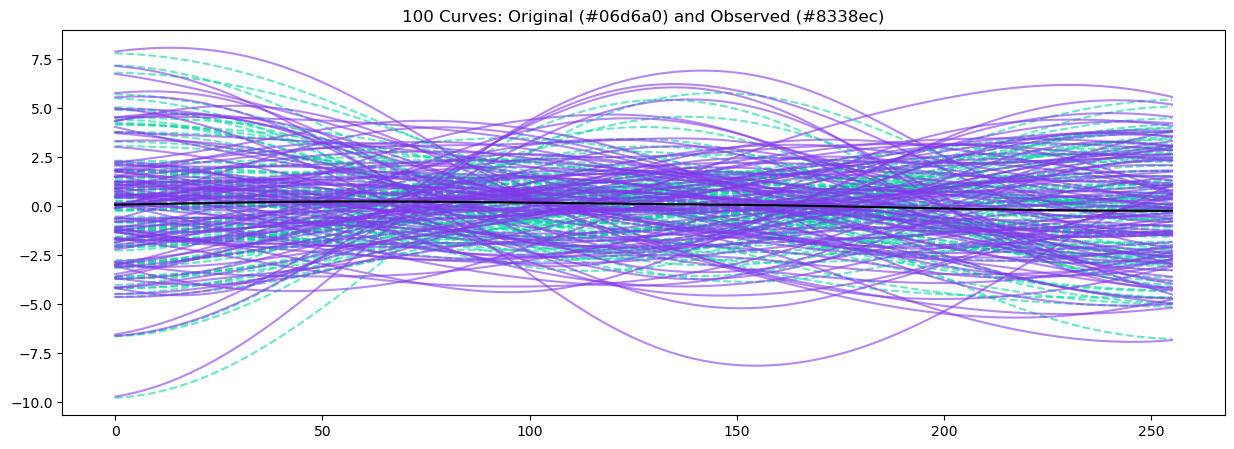

In [7]:
# Simulação

# PARÂMETROS
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

# PROCESSO ARIMA PARA DINÂMICAS FUNCIONAIS NÃO OBSERVADAS

def simulate_ar1(phi, n, sigma2=1.5):
    x = np.zeros(n)
    eps = np.random.normal(scale=np.sqrt(sigma2), size=n)
    for t in range(1, n):
        x[t] = phi * x[t-1] + eps[t]
    return x

xi1 = simulate_ar1(-0.65, n)
xi2 = simulate_ar1( 0.40, n)

# GERA DADOS FUNCIONAIS NÃO OBSERVADOS, X(t)

X = np.zeros((nt, n))

for ii in range(n):
    X[:, ii] = (
        xi1[ii] * np.sqrt(2) * np.cos(np.pi * u[:, 0]) +
        xi2[ii] * np.sqrt(2) * np.cos(2 * np.pi * u[:, 0])
    )


# ADICIONA RUIDO À SÉRIE DE SENO 
mEps = np.zeros((nt, n))

for ii in range(n):
    for jj in range(1, 11):
        mEps[:, ii] += (
            norm.rvs(scale=1.0) * np.sqrt(2) *
            np.sin(np.pi * u[:, 0] * jj) / (2 ** (jj - 1))
        )

# DADOS FUNCIONAIS OBSERVADOS: Y(t) = X(t) + epsilon(t)
Y = X + mEps


plt.figure(figsize=(15,5))


color_original = "#06d6a0"
plt.plot(X, alpha=.6, c=color_original, linestyle="--",label="Unobserved")

color_observed = "#8338ec"
plt.plot(Y, alpha=.6, c=color_observed, label="Observed")

plt.plot(np.mean(Y,axis=1), c="black")

plt.title(f"{n} Curves: Original ({color_original}) and Observed ({color_observed})")

plt.show()

In [8]:
n = 100          # sample size (curves)
d = 2            # dimension parameter
nt = 256         # number of grid points
u = np.linspace(0.01, 0.99, nt)[:, None]  # nt x 1 grid
N = 3            # wavelet decomposition level

eigenvalues_B, eigenvectors_B = W_dFPC(Y, nt, N)

c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\anaconda3\envs\densities4risk\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


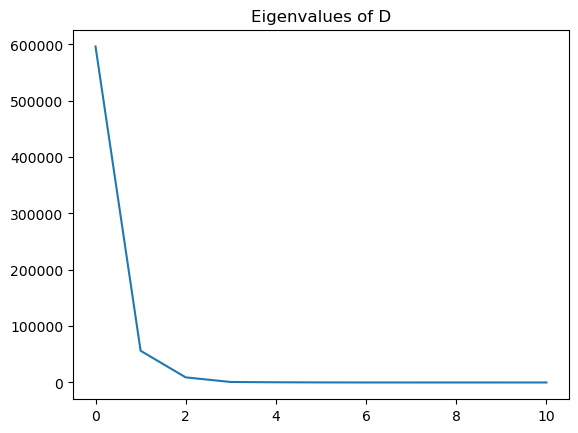

In [9]:
plt.figure()

plt.plot(eigenvalues_B[:11])

plt.title("Eigenvalues of D")

plt.show()

In [10]:
# proportion of the total eigenvalue mass contained in the first 4 eigenvalues
print(np.linalg.norm(eigenvalues_B[:4], 1) / np.linalg.norm(eigenvalues_B, 1))

0.9980202137609148


In [ ]:
#C:\Users\user\Projetos\densities4risk\resources\wavelet_estimation_fonseca\Fertilidade_Australia\03\Autralia_Fert_Rate_WavDimEst.m

# h1_hat =  waverec(B(:,1),Lw,wname);
# h2_hat =  waverec(B(:,2),Lw,wname);
# h3_hat =  waverec(B(:,3),Lw,wname);
# h4_hat =  waverec(B(:,4),Lw,wname);
# h5_hat =  waverec(B(:,5),Lw,wname);


# p = 5;  % lag máximo utilizado
# vw = [.1,.3,.5]'; % vetor de pesos
# %vw = vw/norm(vw);
# delta = length(vw); % número de pesos usados
# nt = 1000;  % número de pontos usados para cada ano
# u = linspace(13,52,nt);  % nt valores igualmente espaçados de 13 a 52
# du = u(2) - u(1);
# SmoLogFertRate = zeros(nt,n);
# for k=2:91
#     fspl = fit(logFerRate(2:10,1),logFerRate(2:10,k),'smoothingspline');
#     SmoLogFertRate(:,(k-1)) = fspl(u);
# end

# % esse vetor terá a média de um determinado coeficiente
# % ao longo dos n dias
# mu_dec = mean(SmoLogFertRate,2);

# % matriz com os desvios dos coeficientes em relação à
# % média dos coeficientes num mesmo dia
# C = SmoLogFertRate - mu_dec*ones(1,n);

# % funcional observado centrado
# mat_G = du*(C'*C);

# % matriz com os produtos internos dos funcionais centrados multiplicados
# % pelos pesos
# Zk = zeros(n-p-delta+1,n-p-delta+1,p-delta+1);
# for k=delta:(p-delta+1)
#     mat_Z = FuncMatProdYcentAggregVet( C, vw, p, k);
#     Zk(:,:,k) = du*mat_Z;
# end

In [10]:
import numpy as np

def W_dFPC_estimation(
        Y: np.ndarray,
        nt: int,
        N: int = 3,
        wavelet_: str = 'db2',
        p: int = 5,
        d: int = 3       # <<< number of components to use in reconstruction
    ):
    """
    Wavelet-domain functional principal component estimation (Pinheiro-Fonseca)
    returns mean estimate and reconstructed curves.
    """

    import pywt
    import numpy as np

    n = Y.shape[1]

    # ----- number of wavelet coeffs per curve -------
    def wavedec_sizes(nt, wavelet_, N):
        coeffs = pywt.wavedec(np.zeros(nt), wavelet_, level=N)
        sizes = [c.size for c in coeffs]
        return sizes, sum(sizes)

    sizes, J = wavedec_sizes(nt, wavelet_, N)

    # ----- "A" matrix -----
    A = np.zeros((J, n))

    for ii in range(n):
        coeffs = pywt.wavedec(Y[:, ii], wavelet=wavelet_, level=N)
        A[:, ii] = np.concatenate(coeffs)

    # ----- mean coeffs -----
    mu_A = np.mean(A, axis=1, keepdims=True)
    C = A - mu_A

    # ----- lagged covariance D -----
    C1 = C[:, :n - p]
    D1 = np.zeros((n - p, n - p))

    for k in range(1, p + 1):
        Ct = C[:, k:(n - p + k)]
        D1 += Ct.T @ Ct

    D = C1 @ D1 @ C1.T / ((n - p) ** 2)

    # eigendecomposition (+ ordering)
    L, B = np.linalg.eig(D)
    idx = np.argsort(-L)

    L = L[idx]
    B = B[:, idx]

    # ----- reconstruct functional mean -----
    # split wavelet vector into coeff lists
    def vec2coeffs(vec):
        coeffs = []
        pos = 0
        for s in sizes:
            coeffs.append(vec[pos:pos+s])
            pos += s
        return coeffs

    mu_hat = pywt.waverec(vec2coeffs(mu_A[:, 0]), wavelet_)

    # ----- reconstruct eigenfunctions h_m -----
    H = np.zeros((nt, d))
    for m in range(d):
        coeffs_m = vec2coeffs(B[:, m])
        H[:, m] = pywt.waverec(coeffs_m, wavelet_)

    # ----- compute scores -----
    scores = B[:, :d].T @ C      # shape (d, n)

    # ----- reconstruct curves -----
    Yhat = np.zeros_like(Y)
    for t in range(n):
        Yhat[:, t] = mu_hat + H @ scores[:, t]

    return mu_hat, Yhat, L, H, scores

In [22]:
dimensions = 5
mu_hat, Yhat, L, H, scores = W_dFPC_estimation(Y, nt, d=dimensions)

C:\Users\user\AppData\Local\Temp\ipykernel_9768\610844596.py:73: ComplexWarning: Casting complex values to real discards the imaginary part
  H[:, m] = pywt.waverec(coeffs_m, wavelet_)
C:\Users\user\AppData\Local\Temp\ipykernel_9768\610844596.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
  Yhat[:, t] = mu_hat + H @ scores[:, t]


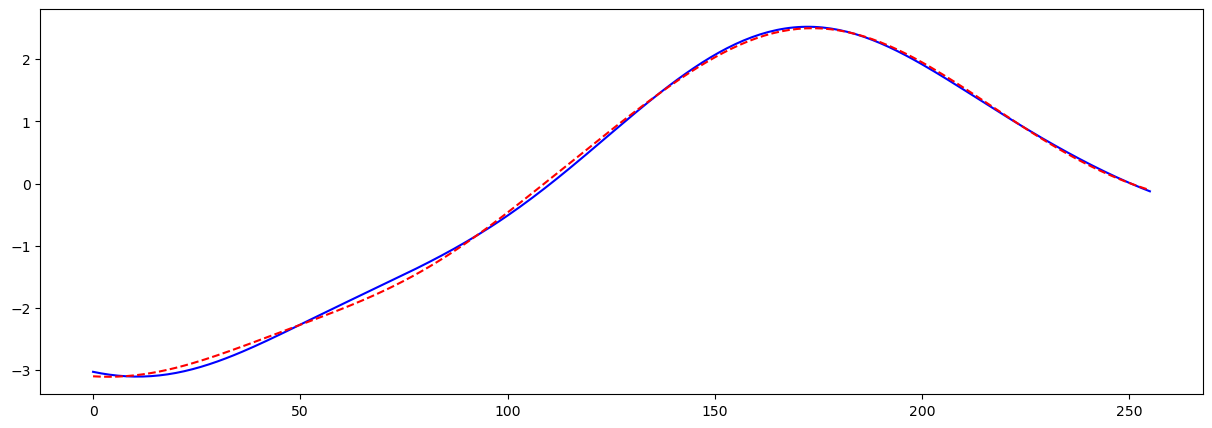

In [23]:
t=75

plt.figure(figsize=(15,5))

plt.plot(Y[:,t], label="Y", c="blue")
plt.plot(Yhat[:,t], label="Yhat", c="red", linestyle="--")

plt.show()

In [ ]:
import pywt
import numpy as np

def wavedec_sizes(signal_length, wavelet_name, level):
    """
    Compute expected pywt.wavedec sizes:
      returns sizes = [len(A_N), len(D_N), ..., len(D_1)]
      and total = sum(sizes)
    """
    w = pywt.Wavelet(wavelet_name)
    F = w.dec_len
    L = signal_length

    lengths = []
    Lj = L
    for j in range(level):
        Lj = (Lj + F - 1) // 2
        lengths.append(Lj)

    sizes = [lengths[-1]] + lengths[::-1]

    total = sum(sizes)
    return sizes, total

# split wavelet vector into coeff lists
def vec2coeffs(vec, sizes):
    coeffs = []
    pos = 0
    for s in sizes:
        coeffs.append(vec[pos:pos+s])
        pos += s
    return coeffs

class W_dFPC:
    def __init__(self, Y):
        self.Y = Y
        self.m, self.T = Y.shape

        #Filled after fit()
        self.Ybar      = None
        self.H         = None
        self.L         = None
        self.B         = None
        self.scores    = None

    def fit(
        Y :      np.ndarray,
        nt:      np.ndarray,
        N :      int         = 3,
        wavelet: str         = 'db2',
        p :      int         = 5,
        d :      int         = 3
        ):

        sizes, J = wavedec_sizes(nt, wavelet, N)
        
        # ----- "A" matrix -----
        A = np.zeros((J, n))

        for ii in range(n):
            coeffs = pywt.wavedec(Y[:, ii], wavelet=wavelet, level=N)
            A[:, ii] = np.concatenate(coeffs)

        # ----- mean coeffs -----
        mu_A = np.mean(A, axis=1, keepdims=True)
        C = A - mu_A

        # ----- lagged covariance D -----
        C1 = C[:, :n - p]
        D1 = np.zeros((n - p, n - p))

        for k in range(1, p + 1):
            Ct = C[:, k:(n - p + k)]
            D1 += Ct.T @ Ct

        D = C1 @ D1 @ C1.T / ((n - p) ** 2)

        # eigendecomposition (+ ordering)
        L, B = np.linalg.eig(D)
        idx = np.argsort(-L)

        L = L[idx]
        B = B[:, idx]
        
        mu_hat = pywt.waverec(vec2coeffs(mu_A[:, 0]), wavelet)

        # ----- reconstruct eigenfunctions h_m -----
        H = np.zeros((nt, d))
        for m in range(d):
            coeffs_m = vec2coeffs(B[:, m])
            H[:, m] = pywt.waverec(coeffs_m, wavelet)

        # ----- compute scores -----
        scores = B[:, :d].T @ C      # shape (d, n)

        # ----- reconstruct curves -----
        Yhat = np.zeros_like(Y)
        for t in range(n):
            Yhat[:, t] = mu_hat + H @ scores[:, t]